# Imports

In [12]:
!pip install tensorflow keras matplotlib scipy opencv-python

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns

import tensorflow as tf
import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, Model

from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50

from keras.applications import InceptionV3



# Utils

### Build image generators

In [14]:
train_df = pd.read_pickle("train_df.pkl")

mask_train = (train_df.label_name == 'Chihuahua') | (train_df.label_name == 'Japanese_spaniel') | (train_df.label_name == 'Maltese_dog')
train_val_df_reduced = train_df.loc[mask_train, :]

train_df_reduced, val_df_reduced = train_test_split(
    train_val_df_reduced, 
    test_size=0.25, 
    stratify=train_val_df_reduced['label_name'],
    random_state=42
)



test_df = pd.read_pickle("test_df.pkl")

mask_test = (test_df.label_name == 'Chihuahua') | (test_df.label_name == 'Japanese_spaniel') | (test_df.label_name == 'Maltese_dog')
test_df_reduced = test_df.loc[mask_test, :]

In [15]:
def data_flow_fct(df, datagen, batch_size=32):

    data_flow = datagen.flow_from_dataframe(
        df, 
        directory='',
        x_col='filename',
        y_col='label_name',
        weight_col=None,
        target_size=(224, 224),
        classes=None,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42
    )
    
    return data_flow

In [16]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
)
train_flow = data_flow_fct(train_df_reduced, datagen_train)
val_flow = data_flow_fct(val_df_reduced, datagen_train)


datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
)
test_flow = data_flow_fct(test_df_reduced, datagen_test)

Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


### Complete training pipeline

In [17]:
results_df = pd.DataFrame(columns=["model_name", "accuracy on test set"])

In [18]:
def create_model_callback(model_name):
    """"
    
    Create model checkpoint and early stopping used for the training

    params:
    model_name: str: name of the future model

    """
    
    model_save_path = f"models/{model_name}.keras"
    
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=False)
    
    callbacks_list = [checkpoint, es]

    return callbacks_list

In [19]:
def train_model(model, callbacks_list, train_flow=train_flow, val_flow=val_flow, nb_epochs=10, batch_size=32):
    with tf.device('/gpu:0'): 
        history = model.fit(train_flow, validation_data=val_flow, batch_size=batch_size, epochs=nb_epochs, callbacks=callbacks_list, verbose=1)
    return history

In [20]:
def plot_loss_and_accuracy(history):
    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy plot
    if 'accuracy' in history.history:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [21]:
def display_matrix_scores(model, model_name, test_flow=test_flow, results_df=results_df):
    
    model.load_weights(f"models/{model_name}.keras")
    predictions = model.predict(test_flow)
    
    y_pred = [np.argmax(pred)  for pred in predictions]
    y_val = [label for label in test_flow.classes]
    
    conf_mat = metrics.confusion_matrix(y_val, y_pred)
    print(metrics.classification_report(y_val, y_pred))
    
    df_cm = pd.DataFrame(conf_mat, index = [label for label in test_flow.class_indices])
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True, cmap="Blues")

    results_df.loc[len(results_df)] = {"model_name":model_name, "accuracy on test set": metrics.f1_score(y_val, y_pred, average="macro")}
    

In [22]:
def complete_ml_pipeline(
        model_name,
        create_model_fct,
        nb_epochs=10,
        batch_size=32,
        create_model_callback_fct=create_model_callback,
        labels=['Chihuahua', 'Japanese_spaniel', 'Maltese_dog'],
        datagen_train=datagen_train,
        datagen_test=datagen_test,
        results_df=results_df      
):
    
    train_val_df_reduced = train_df.loc[train_df.label_name.apply(lambda x: x in labels), :]
    test_df_reduced = test_df.loc[test_df.label_name.apply(lambda x: x in labels), :]

    train_df_reduced, val_df_reduced = train_test_split(
        train_val_df_reduced, 
        test_size=0.25, 
        stratify=train_val_df_reduced['label_name'],
        random_state=42
    )
    
    train_flow = data_flow_fct(train_df_reduced, datagen_train, batch_size=batch_size)
    val_flow = data_flow_fct(val_df_reduced, datagen_train, batch_size=batch_size)

    test_flow = data_flow_fct(test_df_reduced, datagen_test, batch_size=batch_size)

    callbacks_list = create_model_callback_fct(model_name)
    model = create_model_fct(train_flow)
    history = train_model(model, callbacks_list, train_flow=train_flow, val_flow=val_flow, nb_epochs=nb_epochs, batch_size=batch_size)
    plot_loss_and_accuracy(history)
    display_matrix_scores(model, model_name, test_flow)

    return model

# First model : VGG16

In [23]:
def create_model_vgg(train_flow) :

    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(units=len(train_flow.class_indices), activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/10


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3343 - loss: 1.1508
Epoch 1: val_loss improved from inf to 0.91916, saving model to models/vgg.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.3397 - loss: 1.1456 - val_accuracy: 0.6800 - val_loss: 0.9192
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5824 - loss: 0.9114
Epoch 2: val_loss improved from 0.91916 to 0.81433, saving model to models/vgg.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.5789 - loss: 0.9130 - val_accuracy: 0.7867 - val_loss: 0.8143
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5663 - loss: 0.8793
Epoch 3: val_loss improved from 0.81433 to 0.75233, saving model to models/vgg.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5696 - loss: 0.8762 - val_accuracy: 0.8133 - val_loss: 0.7523
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6448 - loss: 0.7392
Epoch 4: val_loss improved from 0.75233 to 0.72805, saving model to models/vgg.keras
8/8 ━━━━━━━━

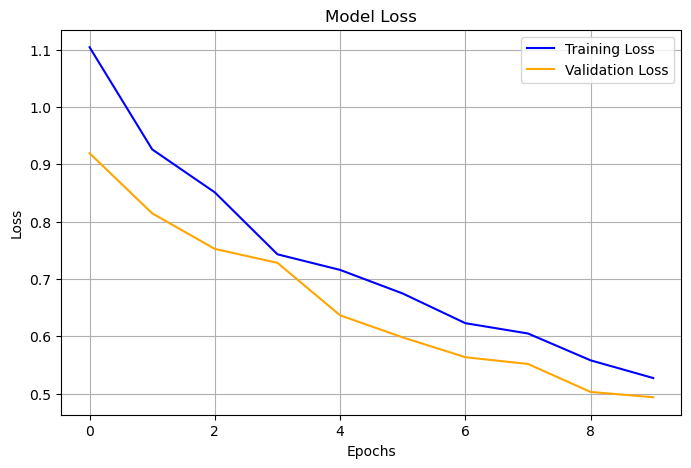

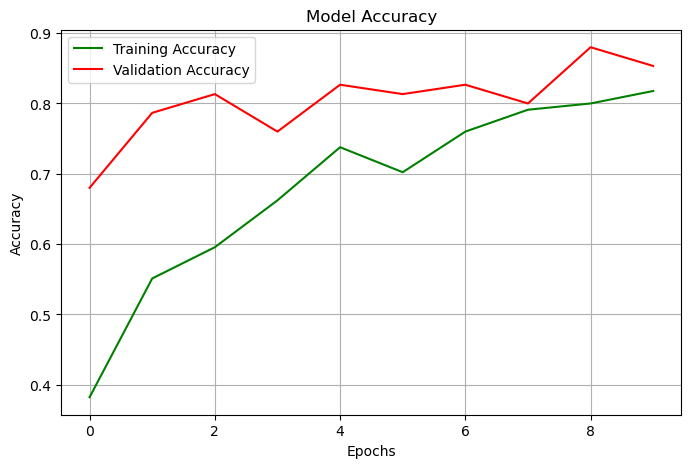

10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step
              precision    recall  f1-score   support

           0       0.25      0.29      0.27        52
           1       0.41      0.56      0.47        85
           2       0.59      0.43      0.49       152

    accuracy                           0.44       289
   macro avg       0.41      0.43      0.41       289
weighted avg       0.47      0.44      0.45       289



<Functional name=functional, built=True>

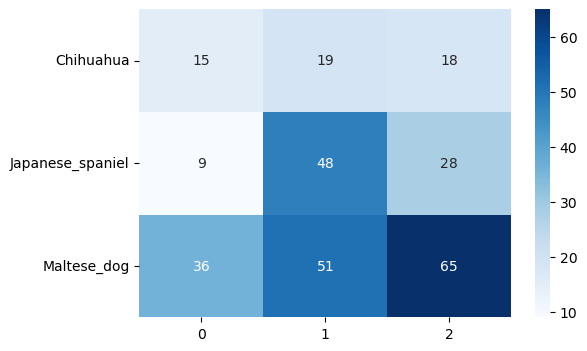

In [24]:
datagen_train_vgg = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=keras.applications.vgg16.preprocess_input
)

datagen_test_vgg = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=keras.applications.vgg16.preprocess_input
)

complete_ml_pipeline("vgg", create_model_vgg, datagen_train=datagen_train_vgg, datagen_test=datagen_test_vgg)

# Second model : Resnet50

In [25]:
def create_model_resnet(train_flow) :
    model0 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(units=len(train_flow.class_indices), activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Epoch 1/20


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3410 - loss: 1.8415   
Epoch 1: val_loss improved from inf to 1.27688, saving model to models/resnet.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3401 - loss: 1.8496 - val_accuracy: 0.3333 - val_loss: 1.2769
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3392 - loss: 1.3677   
Epoch 2: val_loss improved from 1.27688 to 1.22735, saving model to models/resnet.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3375 - loss: 1.3814 - val_accuracy: 0.3333 - val_loss: 1.2274
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3898 - loss: 1.2427   
Epoch 3: val_loss improved from 1.22735 to 1.21708, saving model to models/resnet.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3850 - loss: 1.2469 - val_accuracy: 0.3333 - val_loss: 1.2171
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.3471 - loss: 1.2542
Epoch 4: val_loss improved from 1.21708 to 1.05883, saving model to models/r

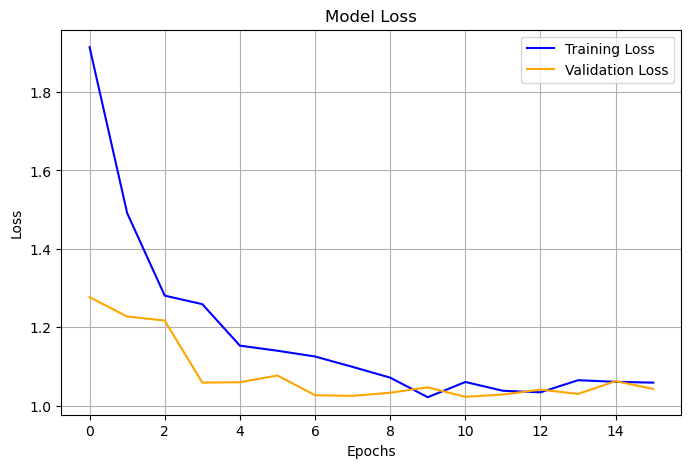

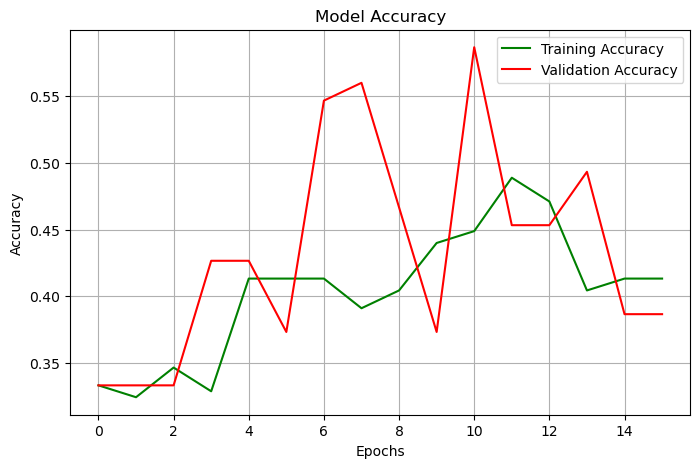

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
              precision    recall  f1-score   support

           0       0.20      0.17      0.18        52
           1       0.35      0.47      0.40        85
           2       0.59      0.51      0.55       152

    accuracy                           0.44       289
   macro avg       0.38      0.38      0.38       289
weighted avg       0.45      0.44      0.44       289



<Functional name=functional_1, built=True>

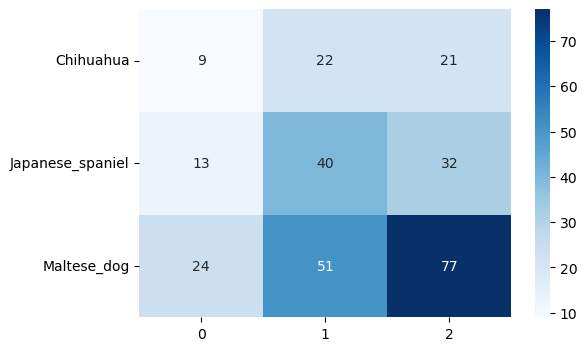

In [26]:
datagen_train_resnet = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=keras.applications.resnet50.preprocess_input
)

datagen_test_resnet = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=keras.applications.resnet50.preprocess_input
)

complete_ml_pipeline("resnet", create_model_resnet, nb_epochs=20, datagen_train=datagen_train_resnet, datagen_test=datagen_test_resnet)

# Third model : InceptionV3

In [27]:
def create_model_inception(train_flow) :
    model0 = InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(units=len(train_flow.class_indices), activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

Found 225 validated image filenames belonging to 3 classes.


Found 75 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,328,099 (85.17 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

None
Epoch 1/20


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.3273 - loss: 1.1914
Epoch 1: val_loss improved from inf to 1.06162, saving model to models/inception.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3329 - loss: 1.1855 - val_accuracy: 0.4133 - val_loss: 1.0616
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.3957 - loss: 1.1262
Epoch 2: val_loss improved from 1.06162 to 1.01953, saving model to models/inception.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 976ms/step - accuracy: 0.3996 - loss: 1.1223 - val_accuracy: 0.4800 - val_loss: 1.0195
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.4821 - loss: 1.0102
Epoch 3: val_loss did not improve from 1.01953
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 854ms/step - accuracy: 0.4789 - loss: 1.0130 - val_accuracy: 0.3467 - val_loss: 1.0528
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.4459 - loss: 1.0537
Epoch 4: val_loss improved from 1.01953 to 1.00876, saving model to models/inception.keras
8/8 ━━━━━━━━━━━━

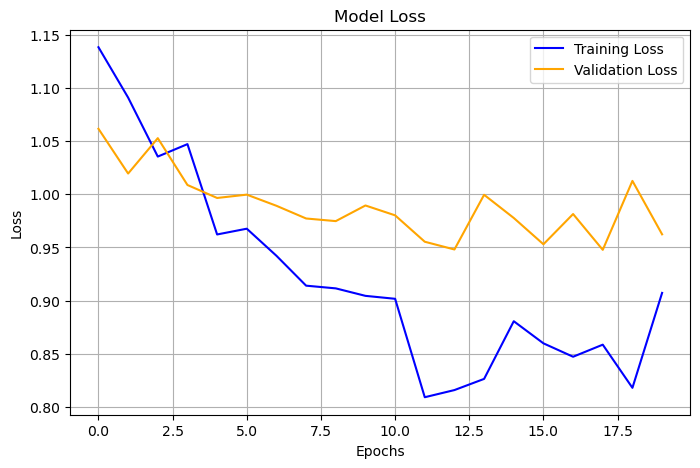

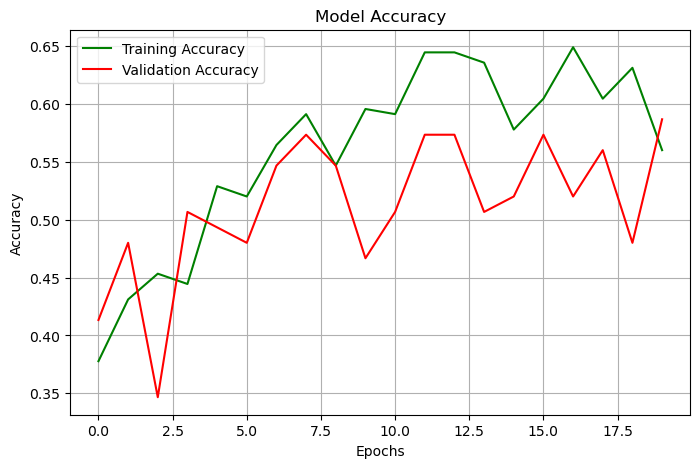

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 770ms/step
              precision    recall  f1-score   support

           0       0.21      0.27      0.24        52
           1       0.33      0.28      0.31        85
           2       0.53      0.52      0.52       152

    accuracy                           0.40       289
   macro avg       0.36      0.36      0.35       289
weighted avg       0.41      0.40      0.41       289



<Functional name=functional_2, built=True>

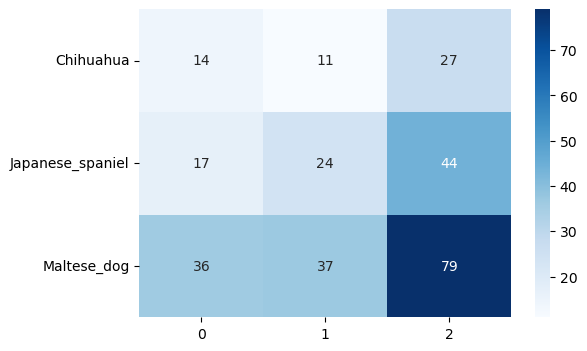

In [28]:
datagen_train_inception = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=keras.applications.inception_v3.preprocess_input
)

datagen_test_inception = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=keras.applications.inception_v3.preprocess_input
)

complete_ml_pipeline("inception", create_model_inception, nb_epochs=20, datagen_train=datagen_train_inception, datagen_test=datagen_test_inception)

In [29]:
results_df

,model_name,accuracy on test set
0,vgg,0.411687
1,resnet,0.377938
2,inception,0.354735


# Final model : VGG16 with more fine-tuning

In [30]:
def create_model_vgg_opti(train_flow) :

    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    predictions = Dense(units=len(train_flow.class_indices), activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.


Found 289 validated image filenames belonging to 3 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,766,339 (60.14 MB)

 Trainable params: 1,051,651 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3363 - loss: 1.3583
Epoch 1: val_loss improved from inf to 1.09767, saving model to models/vgg_opti.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.3394 - loss: 1.3518 - val_accuracy: 0.4667 - val_loss: 1.0977
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4839 - loss: 1.1428
Epoch 2: val_loss improved from 1.09767 to 1.02134, saving model to models/vgg_opti.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4766 - loss: 1.1437 - val_accuracy: 0.5867 - val_loss: 1.0213
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4524 - loss: 1.0977
Epoch 3: val_loss improved from 1.02134 to 0.89186, saving model to models/vgg_opti.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4559 - loss: 1.0895 - val_accuracy: 0.4933 - val_loss: 0.8919
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5865 - loss: 0.9990
Epoch 4: val_loss improved from 0.89186 to 0.85080, saving model to mod

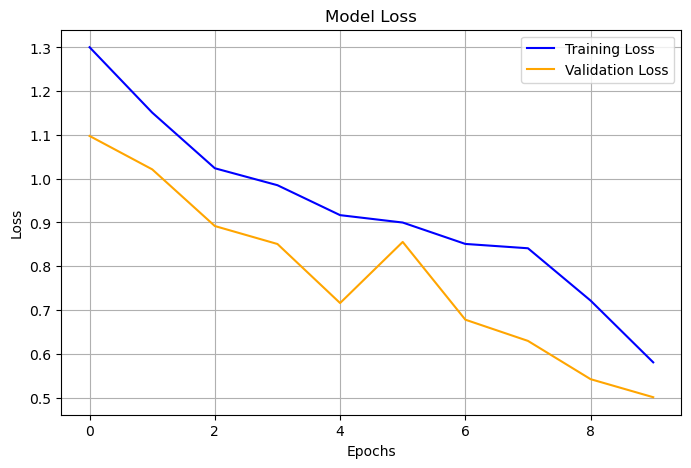

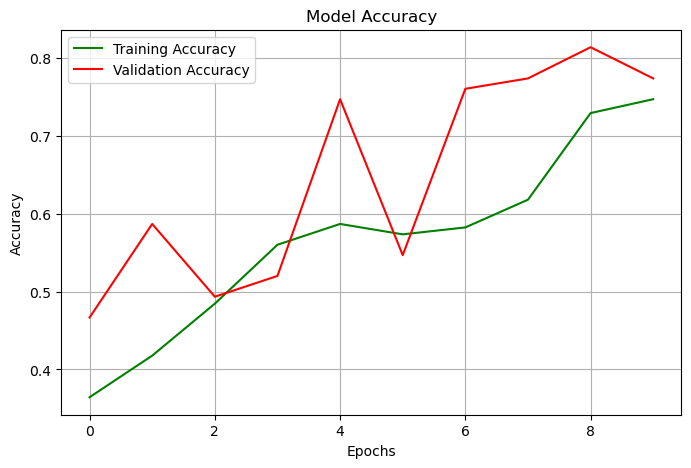

10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step
              precision    recall  f1-score   support

           0       0.24      0.37      0.29        52
           1       0.42      0.45      0.43        85
           2       0.56      0.45      0.50       152

    accuracy                           0.43       289
   macro avg       0.41      0.42      0.41       289
weighted avg       0.46      0.43      0.44       289



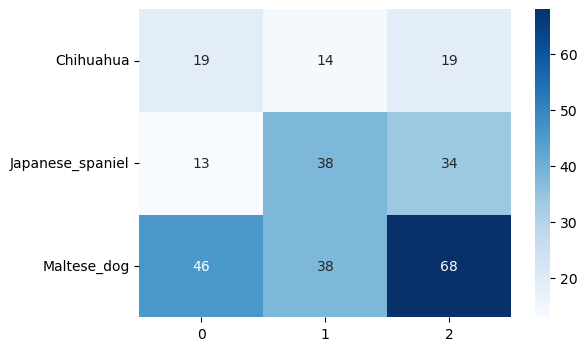

In [31]:
datagen_train_vgg_opti = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=keras.applications.vgg16.preprocess_input
)

datagen_test_vgg_opti = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=keras.applications.vgg16.preprocess_input
)

final_model = complete_ml_pipeline("vgg_opti", create_model_vgg_opti, datagen_train=datagen_train_vgg_opti, datagen_test=datagen_test_vgg_opti)

In [32]:
results_df

,model_name,accuracy on test set
0,vgg,0.411687
1,resnet,0.377938
2,inception,0.354735
3,vgg_opti,0.408254


# Saving

In [33]:
final_model.save("models/vgg_opti.hdf5")


In [34]:
class_indices = train_flow.class_indices

In [52]:
with open("class_indices.pkl", "wb") as file:
    pickle.dump(class_indices, file)